# CS 482: Environmental Navigation Project v.2

In class we talked about the properties of light. One of the topics we discussed was how we could compute the scene lighting of a Lambertian object from its normals and its albedo (and assuming we know where the light is). This process is relatively "simple" once you understand what's going on. For a Lambertian object, the amount of light collected by a light source is proportional to the cosine of the angle between the surface and the light source. So, for every point on the surface $\mathbf{x}$:

$$ \text{Observed Brightness}(\mathbf{x}) = \text{Albedo}(\mathbf{x})\cos(\theta_\mathbf{x}) = \text{Albedo}(\mathbf{x}) \left[ \hat{l} \cdot \hat{n}(\mathbf{x}) \right] $$

where $\hat{l}$ is the *light direction* (normalized) and $\hat{n}(\mathbf{x})$ is the *surface normal* at location $\mathbf{x}$.

For this breakout session, I have provided you with an *albedo matrix* `albedos` (of dimension $m \times n$) and the accompanying *normals* `normals` (of dimension $m \times n \times 3$, where the normal vector at coordinate `i, j` is `normals[i, j]`).

**TASK** Write a function `light_scene` that computes an $m \times n$ "lit scene" image from (1) the albedos, (2) the normals, and (3) the light directions.

I have provided you with both data and some partially-implemented functions for this process. If your `light_scene` function is implemented correctly, the `light_scene_interactive` function I have included below should instantiate an interactive widget with which you can move the light around with sliders and see the effect.

**PLOTS** Include 4 different lightings of the "bunny" scene in your writeup.

*Data and Images* from: 
- Buddah: https://courses.cs.washington.edu/courses/csep576/05wi/projects/project3/project3.htm
- Scholar: http://vision.seas.harvard.edu/qsfs/Data.html

In [1]:
from transformers import AutoImageProcessor, AutoModelForDepthEstimation

checkpoint = "vinvino02/glpn-nyu"

image_processor = AutoImageProcessor.from_pretrained(checkpoint)
model = AutoModelForDepthEstimation.from_pretrained(checkpoint)

c:\Users\matth\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.


In [2]:
from transformers import pipeline

depth_estimator = pipeline(task="depth-estimation", model="LiheYoung/depth-anything-base-hf")
output = depth_estimator("images/book.webp")

In [1]:
output = depth_estimator("http://images.cocodataset.org/val2017/000000039769.jpg")
# This is a tensor with the values being the depth expressed in meters for each pixel
output["predicted_depth"].shape
output["predicted_depth"]

NameError: name 'depth_estimator' is not defined

In [4]:
print(output)

{'predicted_depth': tensor([[[26.3997, 26.3004, 26.3929,  ..., 24.8489, 24.9059, 20.0686],
         [26.2260, 26.2093, 26.3428,  ..., 24.8448, 24.6682, 24.6084],
         [26.0719, 26.0483, 26.1255,  ..., 24.7053, 24.6745, 24.5809],
         ...,
         [43.2635, 43.2343, 43.2892,  ..., 39.0545, 39.2170, 39.0818],
         [43.3636, 43.2703, 43.3899,  ..., 39.1390, 38.9937, 39.0318],
         [38.7509, 43.2191, 43.4387,  ..., 38.5408, 38.3691, 35.3691]]]), 'depth': <PIL.Image.Image image mode=L size=640x480 at 0x20481513950>}


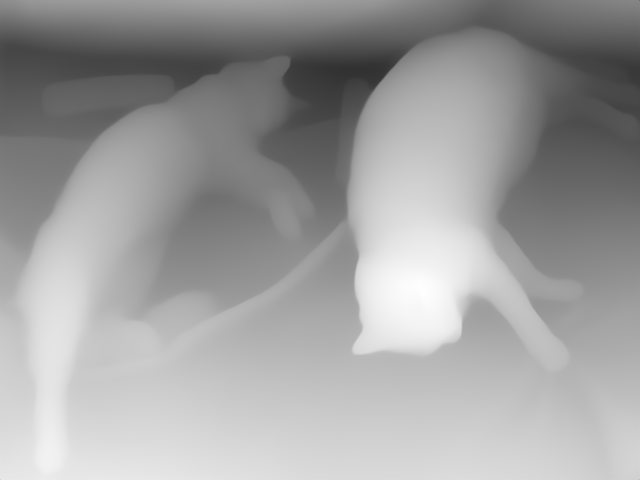

In [3]:
output["depth"]

tensor([[[17.3041, 17.3192, 17.3883,  ..., 20.4376, 20.2981, 16.5202],
         [17.2571, 17.3014, 17.4371,  ..., 20.5958, 20.4077, 20.3002],
         [17.3003, 17.3222, 17.4107,  ..., 20.6522, 20.6061, 20.4927],
         ...,
         [61.0330, 60.9246, 61.0107,  ...,  9.1666,  9.2229,  9.1900],
         [61.2090, 61.0067, 61.1375,  ...,  9.2188,  9.2647,  9.2191],
         [54.6855, 61.1370, 61.1959,  ...,  9.2592,  9.1440,  8.6043]]])


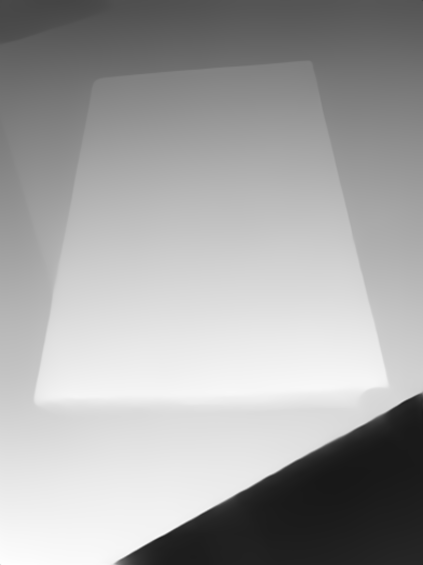

In [5]:
output = depth_estimator("images/book.webp")
# This is a tensor with the values being the depth expressed in meters for each pixel
print(output["predicted_depth"])
output["depth"]

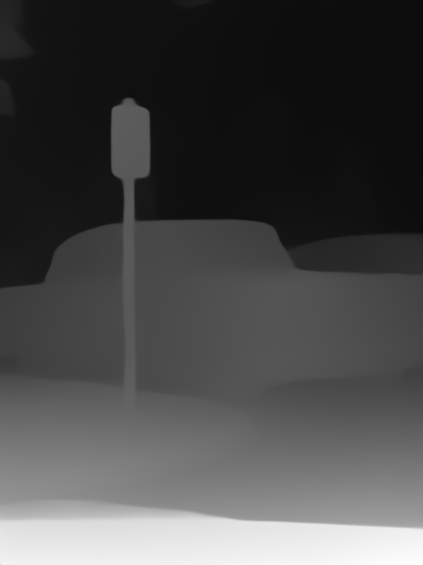

In [5]:
output = depth_estimator("C:/Users/matth/Documents/GitHub/Depth-Room-Navigation/images/condensed_car.webp")
# This is a tensor with the values being the depth expressed in meters for each pixel
output["depth"]

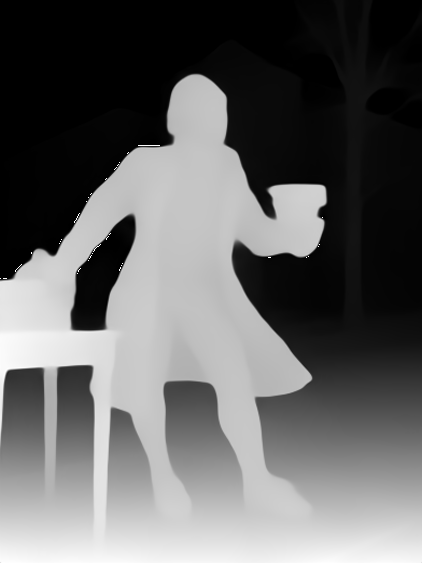

In [6]:
output = depth_estimator("C:/Users/matth/Documents/GitHub/Depth-Room-Navigation/images/mason_statue.webp")
# This is a tensor with the values being the depth expressed in meters for each pixel
output["depth"]

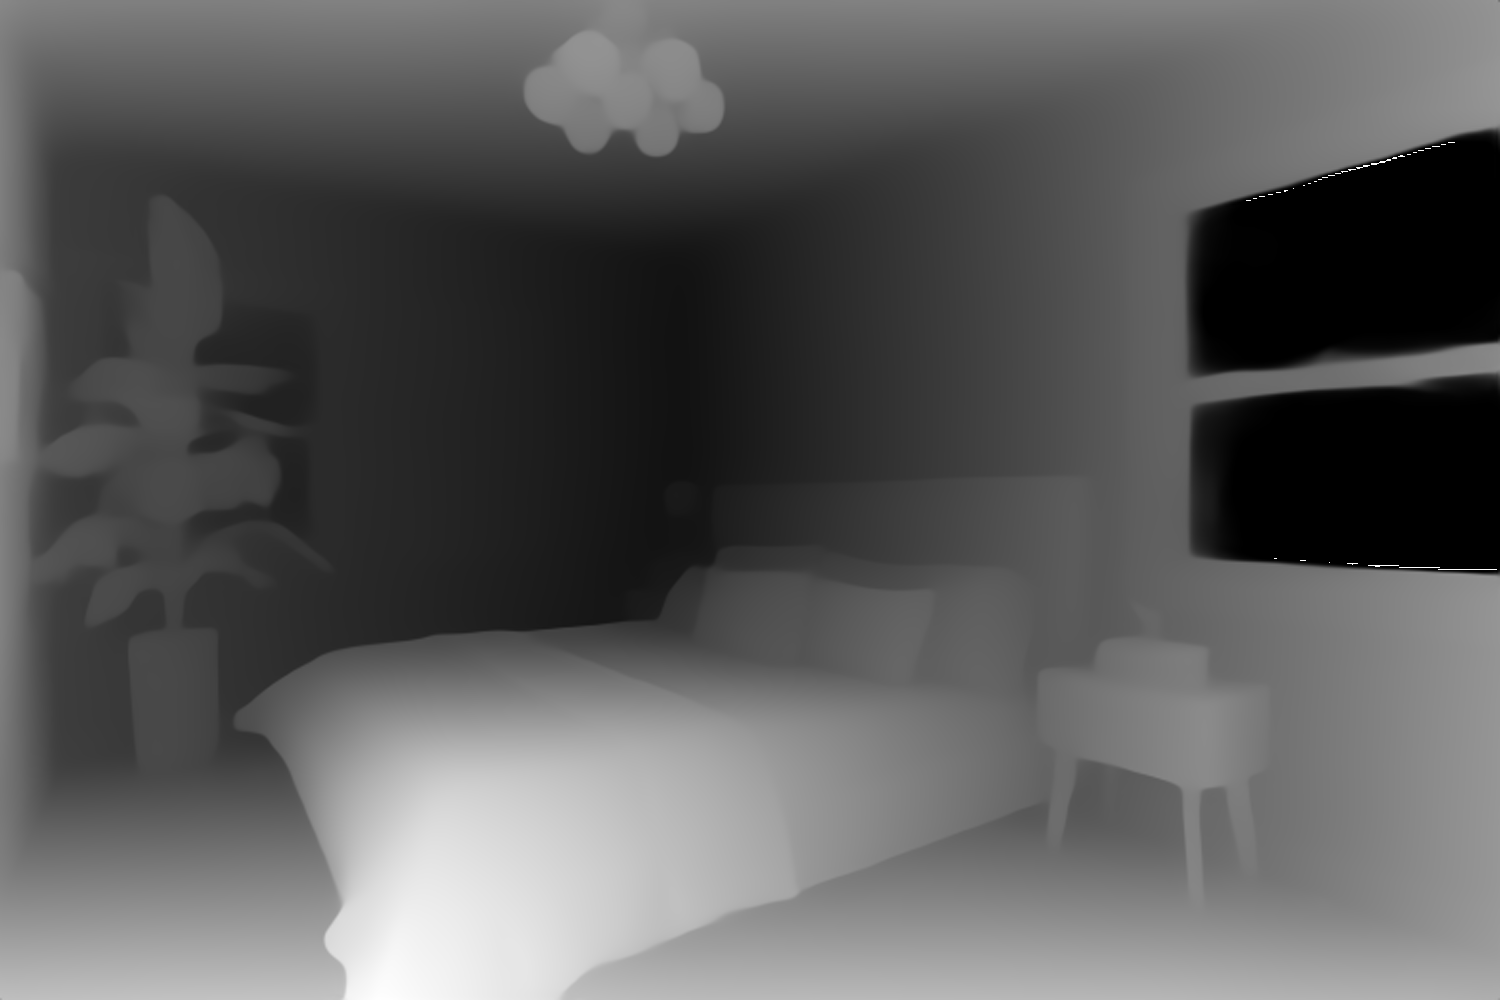

In [7]:
output = depth_estimator("C:/Users/matth/Documents/GitHub/Depth-Room-Navigation/images/room_in_house.jpg")
# This is a tensor with the values being the depth expressed in meters for each pixel
output["depth"]

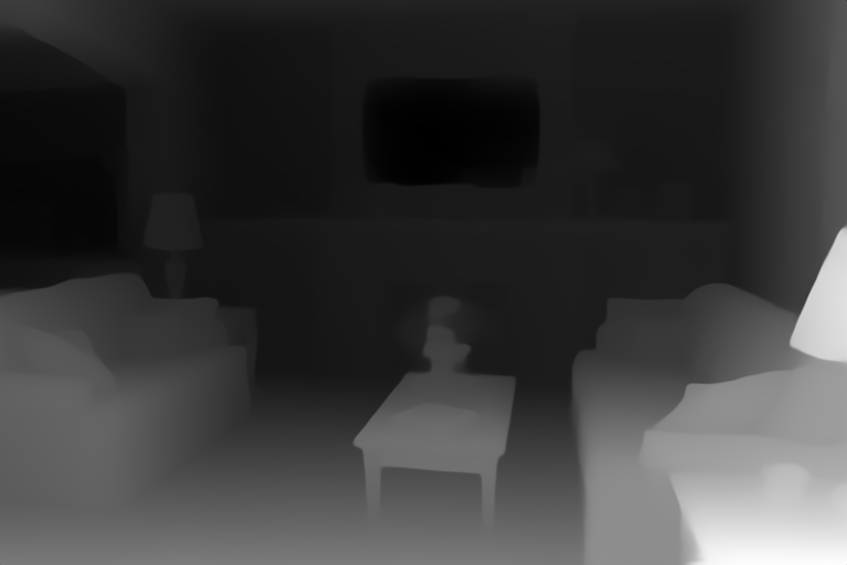

In [8]:
output = depth_estimator("images/room2.webp")
# This is a tensor with the values being the depth expressed in meters for each pixel
output["depth"]

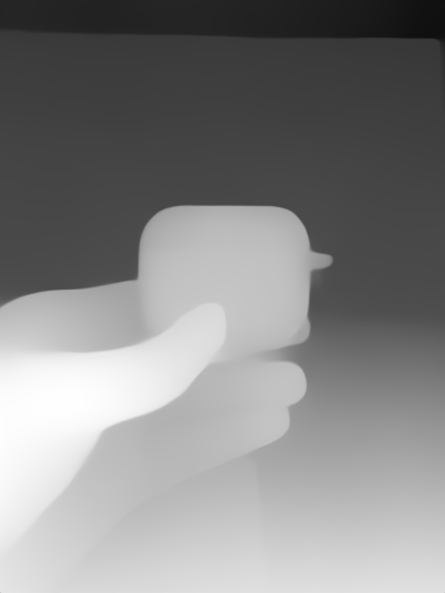

In [8]:
output = depth_estimator("images/airpods2.webp")
# This is a tensor with the values being the depth expressed in meters for each pixel
output["depth"]

In [9]:
output["predicted_depth"]

tensor([[[ 9.9957, 10.0864, 10.1932,  ...,  4.6103,  4.5134,  4.0169],
         [ 9.8364,  9.9961, 10.1638,  ...,  4.6870,  4.6506,  4.6546],
         [ 9.8860, 10.0129, 10.1111,  ...,  4.6192,  4.6728,  4.7096],
         ...,
         [62.0291, 61.9403, 61.9318,  ..., 60.3789, 60.5307, 60.5408],
         [62.1781, 61.9838, 62.0776,  ..., 60.5967, 60.6652, 60.8629],
         [55.5514, 61.9723, 62.1694,  ..., 60.6804, 61.0202, 56.6539]]])

In [1]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
plt.imshow(output["predicted_depth"])

ModuleNotFoundError: No module named 'matplotlib'

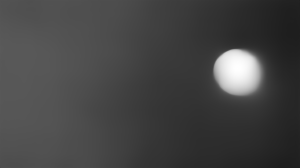

In [4]:
output = depth_estimator("images/earth.jpg")
# This is a tensor with the values being the depth expressed in meters for each pixel
output["depth"]

In [11]:
"""
NOTE: cannot use depth_estimator on a full video.
FIX: convert video to individual frames, run estimator on each frame, and reconvert to video
"""

# output = depth_estimator("videos/IMG_2119.mov")
# This is a tensor with the values being the depth expressed in meters for each pixel
# output["depth"]

'\nNOTE: cannot use depth_estimator on a full video.\nFIX: convert video to individual frames, run estimator on each frame, and reconvert to video\n'

In [15]:
import numpy as np
depth_arr = np.asarray(output["depth"])

print(f"Depth Array Shape = {depth_arr.shape}")
print(depth_arr)
print(np.max(depth_arr))

Depth Array Shape = (565, 423)
[[  0   0   0 ...  98  95  78]
 [  0   0   0 ...  98  97  95]
 [  0   0   0 ...  98  98  98]
 ...
 [180 180 180 ... 175 175 175]
 [178 180 180 ... 175 175 174]
 [160 178 181 ... 174 173 161]]
255


In [16]:
import os
import cv2
import argparse
from transformers import pipeline

depth_estimator = pipeline(task="depth-estimation", model="LiheYoung/depth-anything-base-hf")
directory = "videos/chipotle"
files = os.listdir(directory)

index = 0
"""
# Construct the argument parser and parse the arguments
ap = argparse.ArgumentParser()
ap.add_argument("-ext", "--extension", required=False, default='png', help="extension name. default is 'png'.")
ap.add_argument("-o", "--output", required=False, default='output.mp4', help="output video file")
args = vars(ap.parse_args())
"""

# Arguments: assuming video_folder/[video] + video_folder/frames/[vid_frames]
dir_path = directory + "/frames"
# ext = args['extension']
# output = args['output']
output = directory + "/chipotle.mp4"

# Get the image paths
images = []
for f in os.listdir(dir_path):
        # if f.endswith(ext):
        # f = depth_estimator(directory + "/" + f)
        images.append(f)

# Determine the width and height from the first image
image_path = os.path.join(dir_path, images[0])
frame = cv2.imread(image_path)
cv2.imshow('video',frame)
height, width, channels = frame.shape

# Define the codec and create VideoWriter object
fourcc = cv2.VideoWriter_fourcc(*'mp4v') # Be sure to use lower case
out = cv2.VideoWriter(output, fourcc, 20.0, (width, height))

# For every image in the dir_path folder, read it and write it to the video
for image in images:
        image_path = os.path.join(dir_path, image)
        # frame = cv2.imread(image_path)
        frame = np.asarray(depth_estimator(image_path)["depth"])
        out.write(frame) # Write out frame to video

        cv2.imshow('video',frame)
        if (cv2.waitKey(1) & 0xFF) == ord('q'): # Hit `q` to exit
                break

# Release everything if job is finished
out.release()
cv2.destroyAllWindows()

print("The output video is {}".format(output))

"""
for file in files:
        print(file)
        output = depth_estimator(directory + "/" + file)
        # This is a tensor with the values being the depth expressed in meters for each pixel
        output["depth"]
        index = index + 1
"""


The output video is videos/chipotle/frames/chipotle.mp4


'\nfor file in files:\n        print(file)\n        output = depth_estimator(directory + "/" + file)\n        # This is a tensor with the values being the depth expressed in meters for each pixel\n        output["depth"]\n        index = index + 1\n'

ModuleNotFoundError: No module named 'matplotlib'